In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.geocoders import AzureMaps
from geopy.geocoders import Bing
from geopy.geocoders import HereV7
from geopy.distance import geodesic
import time
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import joblib
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split


# Differntially Private Models
from diffprivlib.models import PCA as DPPCA
from diffprivlib.models import standard_scaler as DPStandardScaler
from diffprivlib.models import GaussianNB as DPGaussianNB
from diffprivlib.models import LogisticRegression as DPLogisticRegression
from diffprivlib.models import RandomForestClassifier as DPRandomForestClassifier


# Non Private Models/PreProcessors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, log_loss,roc_auc_score,average_precision_score,recall_score,f1_score,precision_score

from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

import shap

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

from sklearn.preprocessing import KBinsDiscretizer

from dtreeviz.trees import dtreeviz # remember to load the package

from matplotlib import cm
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D



import seaborn as sns
import copy
import warnings
warnings.filterwarnings("ignore")

# Peek at Original Data

In [2]:
# Load Asset Location Data
asset_location_data = pd.read_csv('train_transaction.csv')

print("Dataset Size:")
print(asset_location_data.shape)

print("First 3 Rows: ")
print(asset_location_data.head(3))
### define input/output features ###
classifier_target = ['isFraud']
classifier_input_cat = ['ProductCD','card4','card6','addr1','addr2','P_emaildomain','R_emaildomain']
classifier_input_num = ['TransactionAmt','card1','card2','card3','card5'] + ['V'+str(elem) for elem in range(1,340)] + ['C'+str(elem) for elem in range(1,15)] + ['D'+str(elem) for elem in range(1,16)] + ['M'+str(elem) for elem in range(1,10)]
null_counts = asset_location_data[classifier_input_num].isnull().sum()
skip_columns_num = list(null_counts[null_counts > 0].sort_values(ascending=False)[:200].index)
null_counts = asset_location_data[classifier_input_cat].isnull().sum()
skip_columns_cat = list(null_counts[null_counts > 0].sort_values(ascending=False)[:1].index)
classifier_input_cat = [elem for elem in classifier_input_cat if elem not in skip_columns_cat]
classifier_input_num = [elem for elem in classifier_input_num if elem not in skip_columns_num]

Dataset Size:
(590540, 394)
First 3 Rows: 
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  

[3 rows x 394 columns]


In [3]:
### Remove samples with na values ###
asset_location_data = asset_location_data[classifier_input_num+classifier_input_cat+classifier_target].dropna()


In [4]:
asset_location_data.reset_index(inplace=True,drop=True)

In [5]:

### type conversion ###
asset_location_data[classifier_input_cat] = asset_location_data[classifier_input_cat].astype(str)
asset_location_data[classifier_input_num] = asset_location_data[classifier_input_num].astype(float)

### Separate fraud and non-fraud cases into different dataframes
fraud_df = asset_location_data[asset_location_data['isFraud'] == 1]
non_fraud_df = asset_location_data[asset_location_data['isFraud'] == 0]


In [6]:
fraud_df.shape,non_fraud_df.shape

((6920, 189), (338733, 189))

In [7]:

# parition dataset by prediction class
asset_location_data_majority = non_fraud_df
asset_location_data_minority = fraud_df

asset_location_data_minority_downsampled = resample(asset_location_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5000,    # to match majority class
                                 random_state=50) # reproducible results

asset_location_data_majority_downsampled = resample(asset_location_data_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=20000,    # to match majority class
                                 random_state=50) # reproducible results

 
# Combine downsampled majority class with upsampled minority class
asset_location_data = pd.concat([asset_location_data_majority_downsampled, asset_location_data_minority_downsampled])

# enc = OrdinalEncoder()

# asset_location_data[[elem for elem in classifier_input if elem!= 'Equipment Address']] = enc.fit_transform(asset_location_data[[elem for elem in classifier_input if elem!= 'Equipment Address']])
asset_location_data = asset_location_data.reset_index(drop=True)

# Exploratory Data Analysis:

In [8]:
def get_feat_dist(feat_list=classifier_input_cat,feat_value=0):
        plt.subplot(1,2,1)
        asset_location_data[asset_location_data['isFraud'] == 1][feat_list[feat_value]].value_counts(normalize=True)[:].plot(kind='bar',figsize=(15,5),title='Column: '+str(feat_list[feat_value])+' (Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
        plt.subplot(1,2,2)
        asset_location_data[asset_location_data['isFraud'] == 0][feat_list[feat_value]].value_counts(normalize=True)[:].plot(kind='bar',figsize=(15,5),title='Column: ' +str(feat_list[feat_value])+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
        plt.figure(figsize=(10,4))

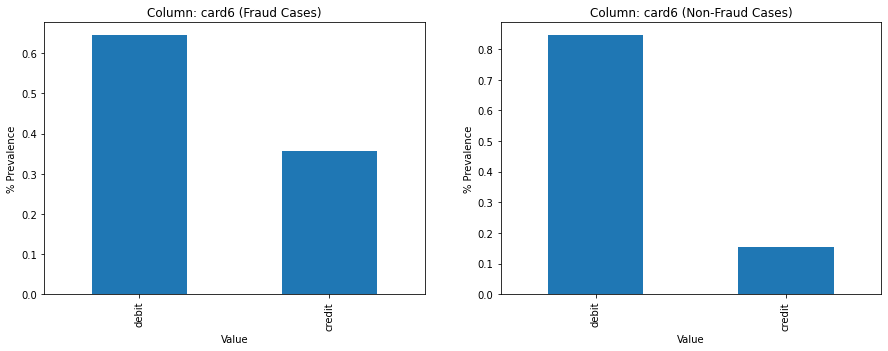

<Figure size 720x288 with 0 Axes>

In [9]:
get_feat_dist(feat_list=classifier_input_cat,feat_value=2)

<AxesSubplot:title={'center':'Column: V12 (Non-Fraud Cases)'}, ylabel='Frequency'>

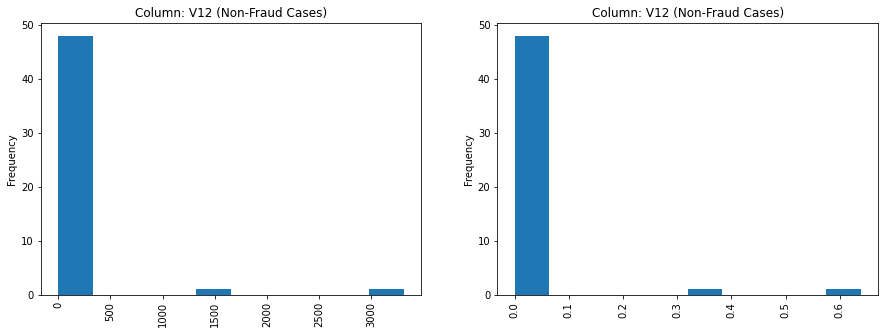

In [10]:
feat_list = classifier_input_num
feat_value = 5

plt.subplot(1,2,1)
asset_location_data[asset_location_data['isFraud'] == 1][feat_list[feat_value]].value_counts(normalize=False,bins=50)[:].plot(kind='hist',figsize=(15,5),title='Column: ' +str(feat_list[feat_value])+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')
plt.subplot(1,2,2)
asset_location_data[asset_location_data['isFraud'] == 0][feat_list[feat_value]].value_counts(normalize=True,bins=50)[:].plot(kind='hist',figsize=(15,5),title='Column: ' +str(feat_list[feat_value])+' (Non-Fraud Cases)',rot=90,ylabel='% Prevalence',xlabel='Value')


# Final Preprocessing Before Model Training

In [11]:
classifier_target

['isFraud']

In [12]:
classifier_input_num

['TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V41',
 'V42',
 'V43',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 '

In [13]:
classifier_input_cat

['ProductCD', 'card4', 'card6', 'addr1', 'addr2', 'P_emaildomain']

In [14]:

# Define Input and Target DF #
X = asset_location_data[classifier_input_cat+classifier_input_num]
y = asset_location_data[classifier_target]

features = X.columns


# Split Into Train and Test Data to Prevent Information Leakage #
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Ordinal Encoding for Categorical Features #
enc = OrdinalEncoder()
enc.fit(X[classifier_input_cat])

X_train[classifier_input_cat] = enc.transform(X_train[classifier_input_cat])
X_test[classifier_input_cat] = enc.transform(X_test[classifier_input_cat])

# PCA for Numerical Features #
pca = PCA(n_components=2)
pca.fit(X_train[classifier_input_num])
X_train['PCA1'] = pca.transform(X_train[classifier_input_num])[:,0]
X_train['PCA2'] = pca.transform(X_train[classifier_input_num])[:,1]
X_test['PCA1'] = pca.transform(X_test[classifier_input_num])[:,0]
X_test['PCA2'] = pca.transform(X_test[classifier_input_num])[:,1]


# Standard Scaling for Numerical Features #
std = StandardScaler()

X_train[classifier_input_num] = std.fit_transform(X_train[classifier_input_num])
X_test[classifier_input_num] = std.transform(X_test[classifier_input_num])

X_train = X_train[classifier_input_cat+['PCA1','PCA2']]
X_test = X_test[classifier_input_cat+['PCA1','PCA2']]



In [15]:
X_train.shape,X_test.shape

((20000, 8), (5000, 8))

# Fraud Modelling

In [16]:
# # Naive Bayes Model
# nb = GaussianNB()

# # lr = LogisticRegression(random_state=42)

# rf = RandomForestClassifier(random_state=42)

# dt = DecisionTreeClassifier(random_state=42)

# ada = AdaBoostClassifier(random_state=42)

# knn = KNeighborsClassifier()

# # lin_svm = SVC(kernel="linear", C=0.025)

# rbf_svm = SVC(probability=True,kernel='rbf')

# nb.fit(X_train,y_train)
# # lr.fit(X_train,y_train)
# rf.fit(X_train,y_train)
# dt.fit(X_train,y_train)
# ada.fit(X_train,y_train)
# knn.fit(X_train,y_train)
# # lin_svm.fit(X_train,y_train)
# rbf_svm.fit(X_train,y_train)



# models = {'Random Forest': rf,'AdaptiveGB':ada,'Naive Bayes':nb,'Decision Tree':dt,'KNeighbors':knn,'RBF SVM':rbf_svm}

# # RandomForest Model


In [50]:
# X_train.loc[[20000,20999,22000,23000,24000,24500],:]


def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

sample_data_inp = copy.deepcopy(X_test)
sample_data_label = copy.deepcopy(y_test)
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

actual = [int(elem) for elem in sample_data_label.values]
predicted = [int(classifier.predict(elem.reshape(1, -1))) for elem in sample_data_inp.values]

sample_data_inp['Actual'] = actual
sample_data_inp['Predicted'] = predicted

sample_data_tp_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 1) & (sample_data_inp['Actual'] == 1)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_fn_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 0) & (sample_data_inp['Actual'] == 1)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_fp_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 1) & (sample_data_inp['Actual'] == 0)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_tn_downsampled = resample(sample_data_inp[(sample_data_inp['Predicted'] == 0) & (sample_data_inp['Actual'] == 0)], 
                                 replace=False,     # sample with replacement
                                 n_samples=4,    # to match majority class
                                 random_state=6) # reproducible results

sample_data_positive_class = pd.concat([sample_data_tp_downsampled,sample_data_fn_downsampled])
sample_data_negative_class = pd.concat([sample_data_fp_downsampled,sample_data_tn_downsampled])

for c in sample_data_positive_class.columns:
    if c not in ['Actual','Predicted']:    
        sample_data_positive_class[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_positive_class[c].values]
        sample_data_negative_class[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_negative_class[c].values]


sample_data_positive_class['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                             str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                             str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                             str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                            for elem in zip(sample_data_positive_class['Predicted'].values,sample_data_positive_class['Actual'].values)]
sample_data_negative_class['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                             str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                             str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                             str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                            for elem in zip(sample_data_negative_class['Predicted'].values,sample_data_negative_class['Actual'].values)]
 
sample_data_positive_class['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_positive_class['Actual'].values]
sample_data_negative_class['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_negative_class['Actual'].values]


# sample_data_negative_class['Actual'] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_negative_class[c].values]





index_values_positive = sample_data_positive_class.index
index_values_negative = sample_data_negative_class.index

print("Sample Dataset for Epsilon=None")
print(sample_data_positive_class)
print(sample_data_negative_class)
sample_data_positive_class.to_csv('sample_data_positive_class.csv',index=False)
sample_data_negative_class.to_csv('sample_data_negative_class.csv',index=False)


Sample Dataset for Epsilon=None
      ProductCD  card4  card6   addr1  addr2 P_emaildomain     PCA1     PCA2  \
22050     3.e+0  3.e+0  0.e+0  4.7e+1  7.e+0        4.6e+1   3.9e+3   3.4e+2   
23658     3.e+0  3.e+0  0.e+0   2.e+1  7.e+0        4.6e+1   8.2e+3   2.7e+4   
23302     3.e+0  2.e+0  1.e+0  5.1e+1  7.e+0        4.6e+1  -7.3e+3    2.e+2   
20599     3.e+0  3.e+0  1.e+0  4.7e+1  7.e+0        4.6e+1   7.4e+3   4.5e+3   
20104     3.e+0  3.e+0  1.e+0  4.7e+1  7.e+0        1.6e+1   6.2e+3  -6.4e+2   
23585     3.e+0  3.e+0  1.e+0  1.6e+1  7.e+0        1.6e+1  -2.4e+3  -1.6e+2   
20041     3.e+0  3.e+0  1.e+0   4.e+1  7.e+0        1.6e+1   1.1e+3  -6.1e+2   
21802     3.e+0  1.e+0  0.e+0  2.4e+1  7.e+0        4.6e+1  -7.3e+3   2.0e+2   

                        Actual                Predicted  
22050  \textcolor{green}{True}  \textcolor{green}{True}  
23658  \textcolor{green}{True}  \textcolor{green}{True}  
23302  \textcolor{green}{True}  \textcolor{green}{True}  
20599  \textcol

In [53]:
class_type = 'positive'
epsilons = [1000,100,10,0.1]


if class_type == 'positive':
    sample_data_downsampled = sample_data_positive_class
    index_values = index_values_positive
if class_type == 'negative':
    sample_data_downsampled = sample_data_negative_class
    index_values = index_values_negative


print("Sample Dataset for Epsilon=None")
print(sample_data_downsampled)
# print("Actual:")
# print([int(elem) for elem in sample_data_downsampled['Actual'].values])
# print("Predicted: ")
# print([elem for elem in sample_data_downsampled['Predicted'].values])

for epsilon  in epsilons:

    ### ADD DP-NOISE TO COMPLETE DATASET ###
    X_train_dash = add_dp_noise(X_train,epsilon)
    # sample_data = X_test.loc[[20000,20999,22000,23000,24000,24500],:]

    X_test_dash = add_dp_noise(X_test,epsilon)
    sample_data_itr = copy.deepcopy(pd.concat([X_train_dash,X_test_dash]).loc[index_values,:])
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train_dash,y_train)

    actual = [elem for elem in y_test.loc[index_values,'isFraud']]
    predicted = [int(classifier.predict(elem.reshape(1, -1))) for elem in sample_data_itr.values]
    sample_data_itr['Actual'] = actual
    sample_data_itr['Predicted'] = predicted


    for c in sample_data_itr.columns:
        if c not in ['Actual','Predicted']:    
            sample_data_itr[c] = [ np.format_float_scientific(elem, precision = 1, exp_digits=1) for elem in sample_data_itr[c].values]
            

    sample_data_itr['Predicted'] = [ str('\\textcolor{green}{True}') if elem[0] ==elem[1] and elem[0]==1 else
                                                str('\\textcolor{green}{False}') if elem[0]==elem[1] and elem[0]==0 else
                                                str('\\textcolor{red}{True}') if elem[0]!=elem[1] and elem[0]==1 else
                                                str('\\textcolor{red}{False}') if elem[0]!=elem[1] and elem[0]==0 else None 
                                                for elem in zip(sample_data_itr['Predicted'].values,sample_data_itr['Actual'].values)]
    
    sample_data_itr['Actual'] = [ str('\\textcolor{green}{True}') if elem ==1 else str('\\textcolor{red}{False}') for elem in sample_data_itr['Actual'].values]
    

    print("Sample Dataset for Epsilon="+str(epsilon))
    # print("Actual: ")
    # print(actual)
    # print("Predicted: ")
    # print(predicted)
    print(sample_data_itr)
    sample_data_itr.to_csv('epsilon_'+str(epsilon)+'_'+str(class_type)+'.csv',index=False)


Sample Dataset for Epsilon=None
      ProductCD  card4  card6   addr1  addr2 P_emaildomain     PCA1     PCA2  \
22050     3.e+0  3.e+0  0.e+0  4.7e+1  7.e+0        4.6e+1   3.9e+3   3.4e+2   
23658     3.e+0  3.e+0  0.e+0   2.e+1  7.e+0        4.6e+1   8.2e+3   2.7e+4   
23302     3.e+0  2.e+0  1.e+0  5.1e+1  7.e+0        4.6e+1  -7.3e+3    2.e+2   
20599     3.e+0  3.e+0  1.e+0  4.7e+1  7.e+0        4.6e+1   7.4e+3   4.5e+3   
20104     3.e+0  3.e+0  1.e+0  4.7e+1  7.e+0        1.6e+1   6.2e+3  -6.4e+2   
23585     3.e+0  3.e+0  1.e+0  1.6e+1  7.e+0        1.6e+1  -2.4e+3  -1.6e+2   
20041     3.e+0  3.e+0  1.e+0   4.e+1  7.e+0        1.6e+1   1.1e+3  -6.1e+2   
21802     3.e+0  1.e+0  0.e+0  2.4e+1  7.e+0        4.6e+1  -7.3e+3   2.0e+2   

                        Actual                Predicted  
22050  \textcolor{green}{True}  \textcolor{green}{True}  
23658  \textcolor{green}{True}  \textcolor{green}{True}  
23302  \textcolor{green}{True}  \textcolor{green}{True}  
20599  \textcol

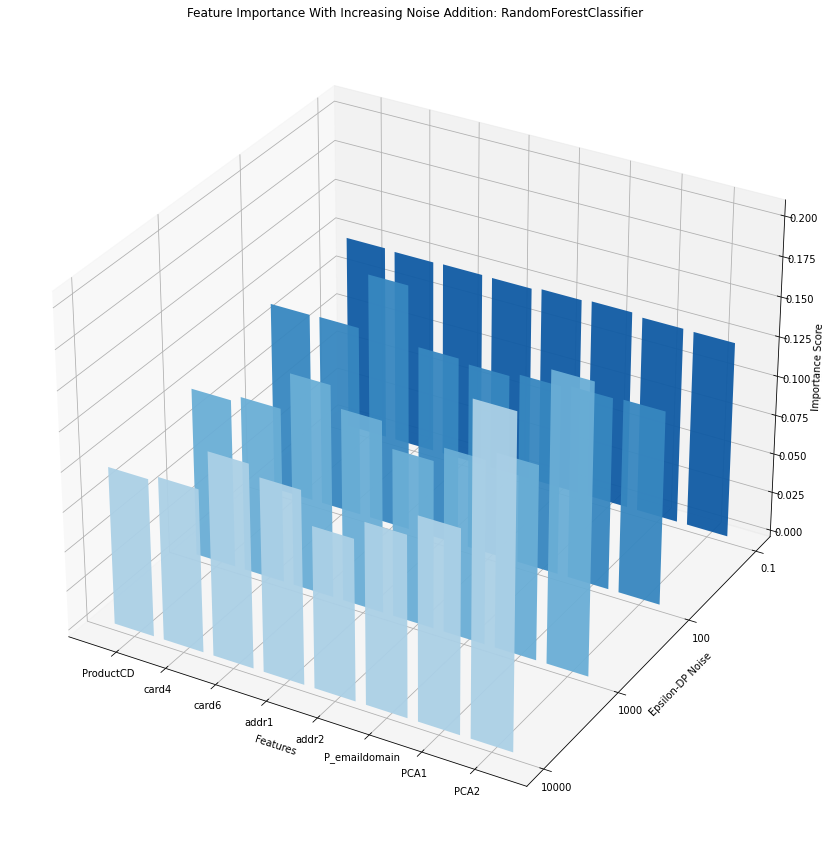

In [20]:
epsilons = [10000,1000,100,0.1]

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm.Blues)

def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

for i,epsilon  in enumerate(epsilons):

    ### ADD DP-NOISE TO COMPLETE DATASET ###
    X_train_dash = add_dp_noise(X_train,epsilon)
    # X_test_dash = add_dp_noise(X,epsilon)
    classifier = RandomForestClassifier()
    classifier.fit(X_train_dash,y_train)
    importances = classifier.feature_importances_

    ax.bar([elem for elem in classifier_input_cat+['PCA1','PCA2']], importances, zs=i*2, zdir='y', alpha=0.95, color=cmap.to_rgba(i))

ax.set_yticks([elem*2 for elem in range(len(epsilons))])
ax.set_yticklabels(epsilons)
ax.set_xlabel('Features')
ax.set_ylabel('Epsilon-DP Noise')
ax.set_zlabel('Importance Score')
ax.set_title('Feature Importance With Increasing Noise Addition: '+str(classifier)[:-2])
plt.show()


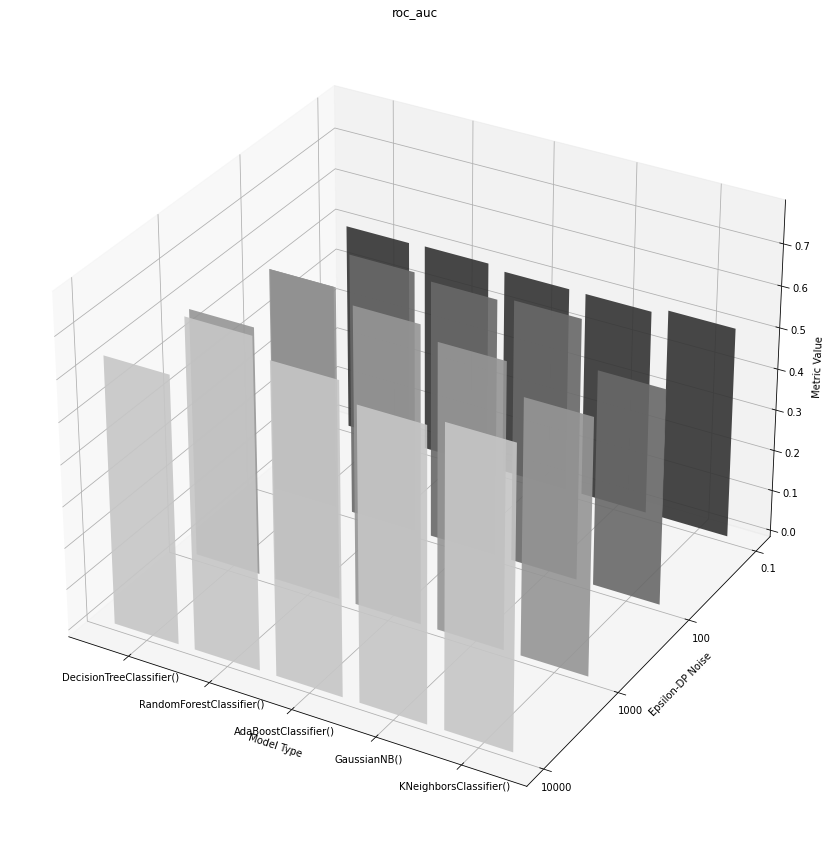

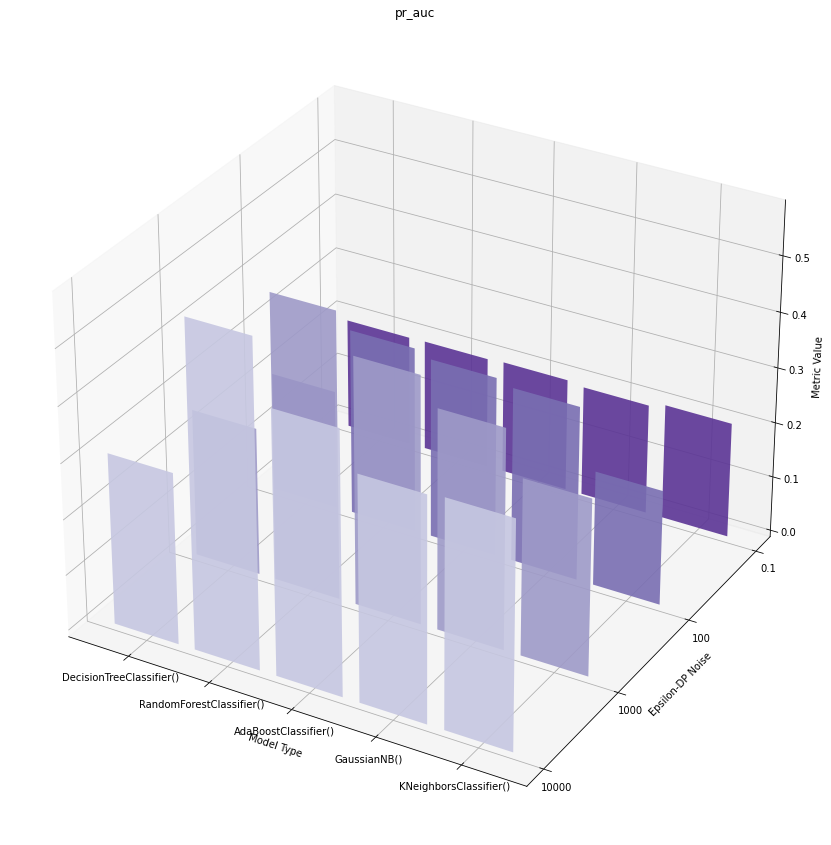

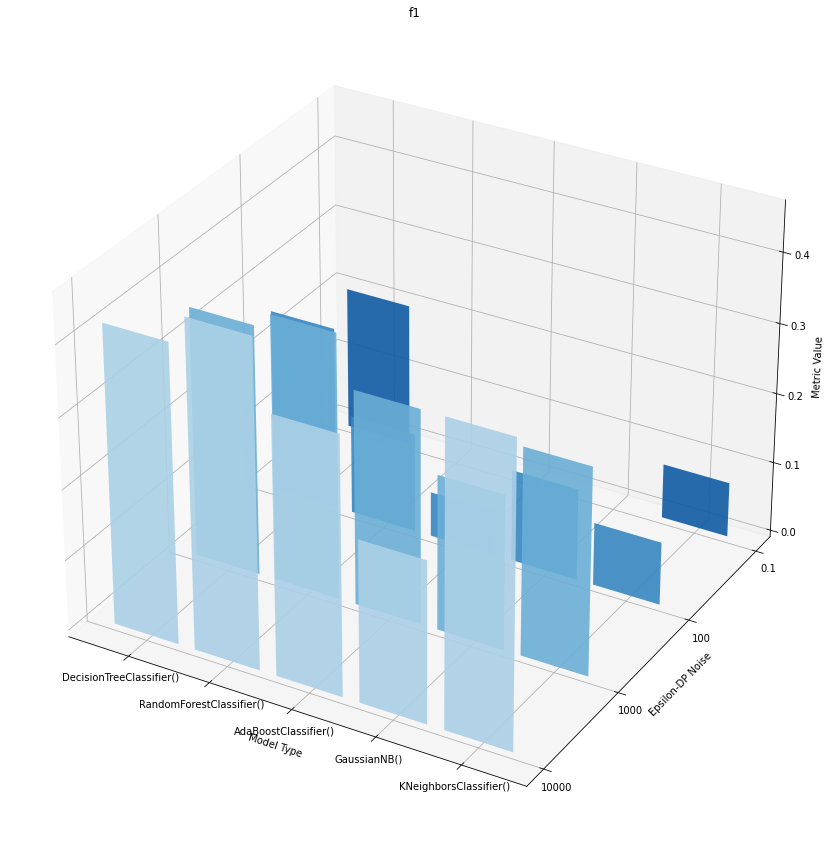

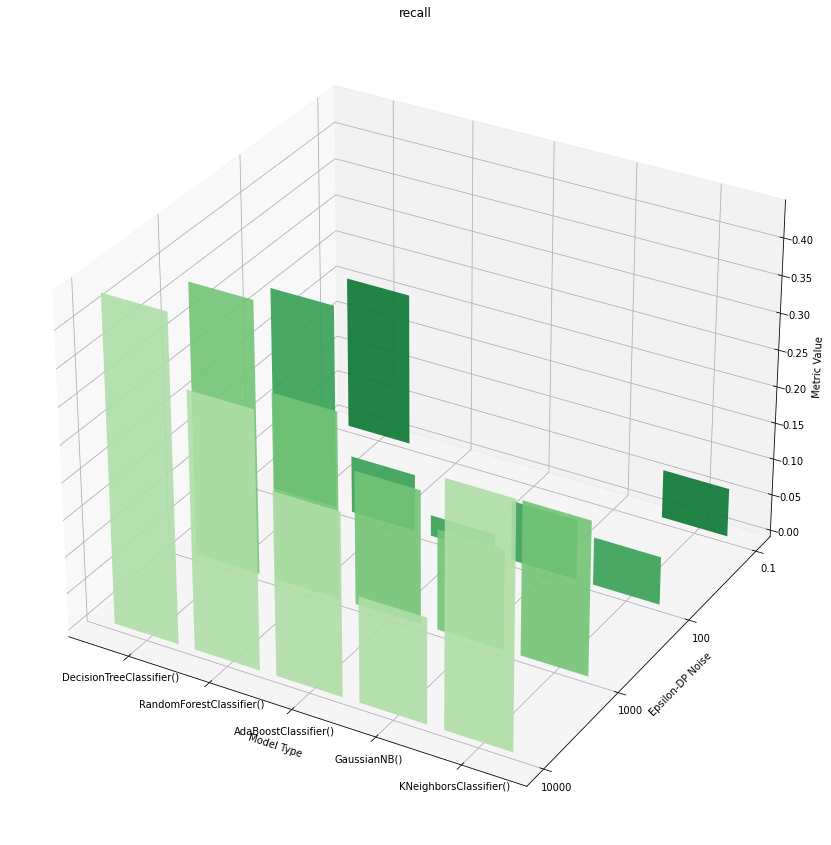

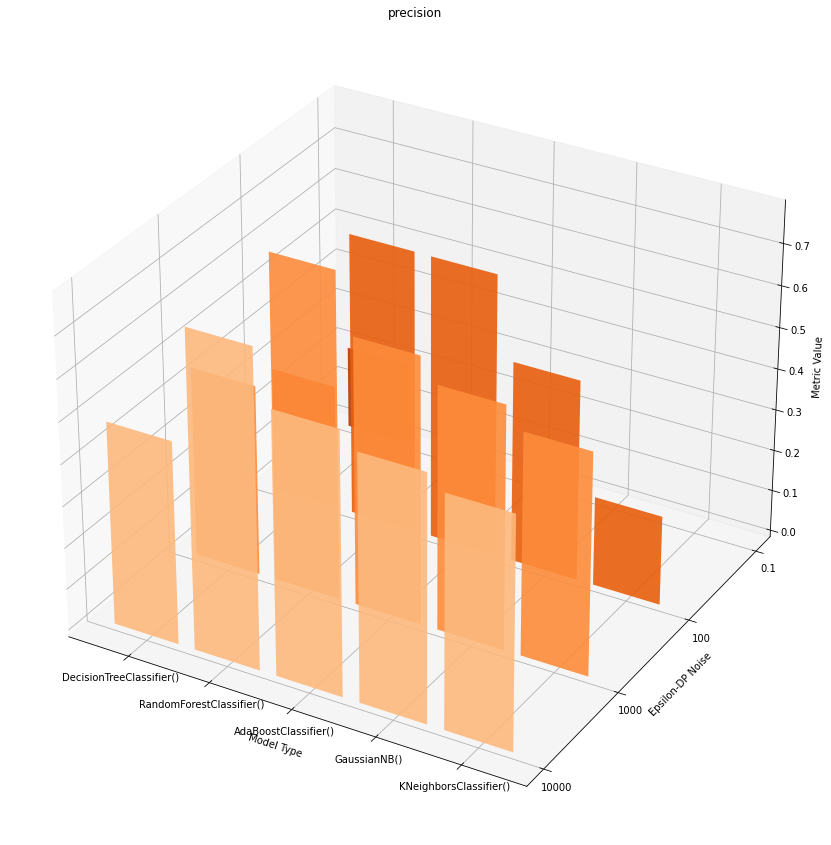

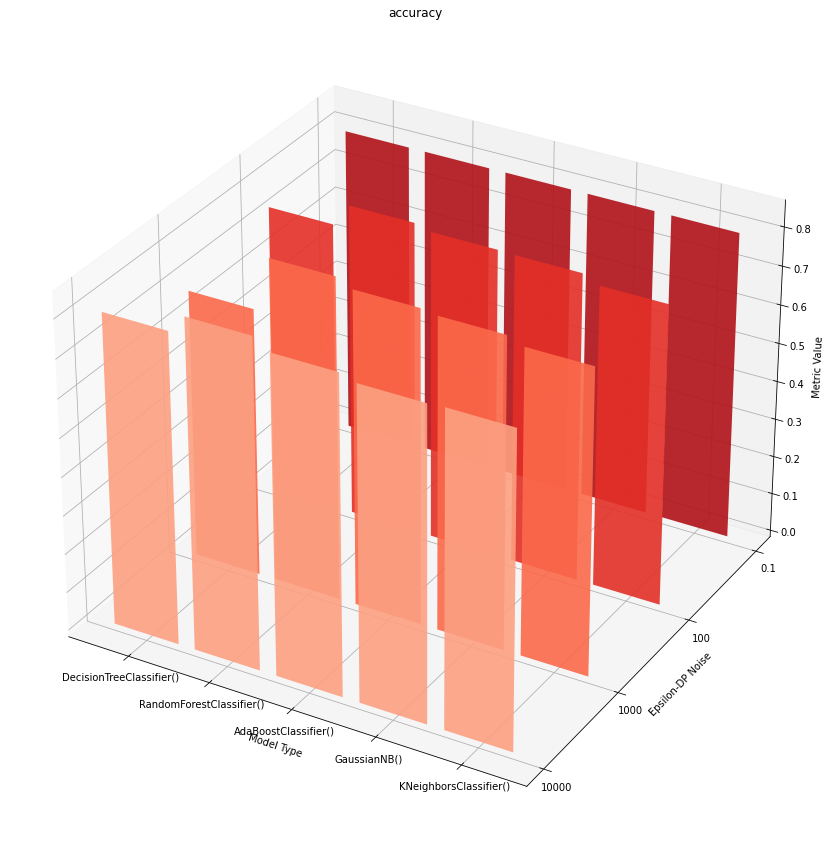

In [46]:
metrics = ['roc_auc','pr_auc','f1','recall','precision','accuracy']
classifiers = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GaussianNB(),KNeighborsClassifier()]
# classifier = classifiers[0]
epsilons = [10000,1000,100,0.1]

# [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
#                     f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
#                     precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

cm_values = [cm.Greys,cm.Purples,cm.Blues,cm.Greens,cm.Oranges,cm.Reds]
cm_dict = {elem[0]:elem[1] for elem in zip(metrics,cm_values)}
def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

for metric in metrics:


    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')

    cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm_dict[metric])


    for i,epsilon  in enumerate(epsilons):

        ### ADD DP-NOISE TO COMPLETE DATASET ###
        X_train_dash = add_dp_noise(X_train,epsilon)
        X_test_dash = add_dp_noise(X_test,epsilon)
        # classifier = RandomForestClassifier()
   
        calculated_metrics = list()

        for classifier in classifiers: 
            classifier.fit(X_train_dash,y_train)
            y_test_pred = classifier.predict(X_test_dash)
            metric_values = [roc_auc_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)]),
                            average_precision_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)]),
                            f1_score(y_test,classifier.predict(X_test_dash)),
                            recall_score(y_test,classifier.predict(X_test_dash)),
                            precision_score(y_test,classifier.predict(X_test)),
                            accuracy_score(y_test,classifier.predict(X_test))] 
            metric_dict = {elem[0]:elem[1] for elem in zip(metrics,metric_values)}
            # metric = roc_auc_score(y_test,[elem[1] for elem in classifier.predict_proba(X_test_dash)])
            # print(metric_dict[metric])
            calculated_metrics.append(metric_dict[metric])
            # print(metrics)
        # tn, fp, fn, tp = confusion_matrix(y_test,y_test_pred,normalize='all').ravel()
        # print([elem for elem in confusion_matrix(y_test,y_test_pred)])
        
        
        # importances = classifier.feature_importances_
        # print(len([str(elem) for elem in classifiers]))
        # print(len([str(elem) for elem in metrics]))

        ax.bar([str(elem) for elem in classifiers], [elem for elem in calculated_metrics], zs=i*2, zdir='y', alpha=0.9, color=cmap.to_rgba(i))

    ax.set_yticks([elem*2 for elem in range(len(epsilons))])
    ax.set_yticklabels(epsilons)
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Epsilon-DP Noise')
    ax.set_zlabel('Metric Value')
    ax.set_title(str(metric))
    plt.show()

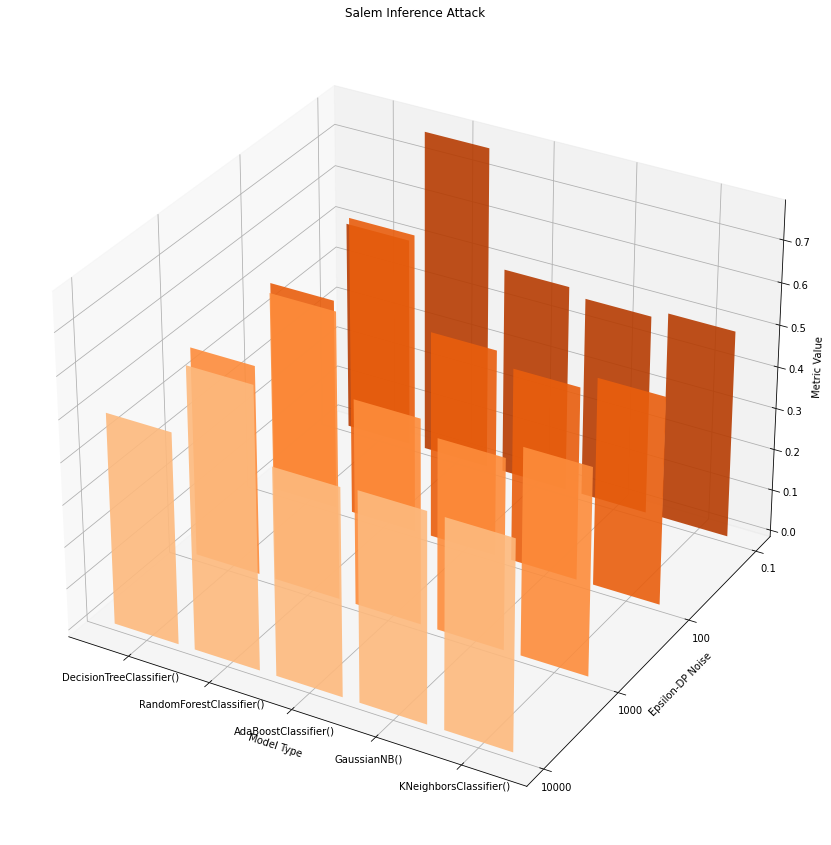

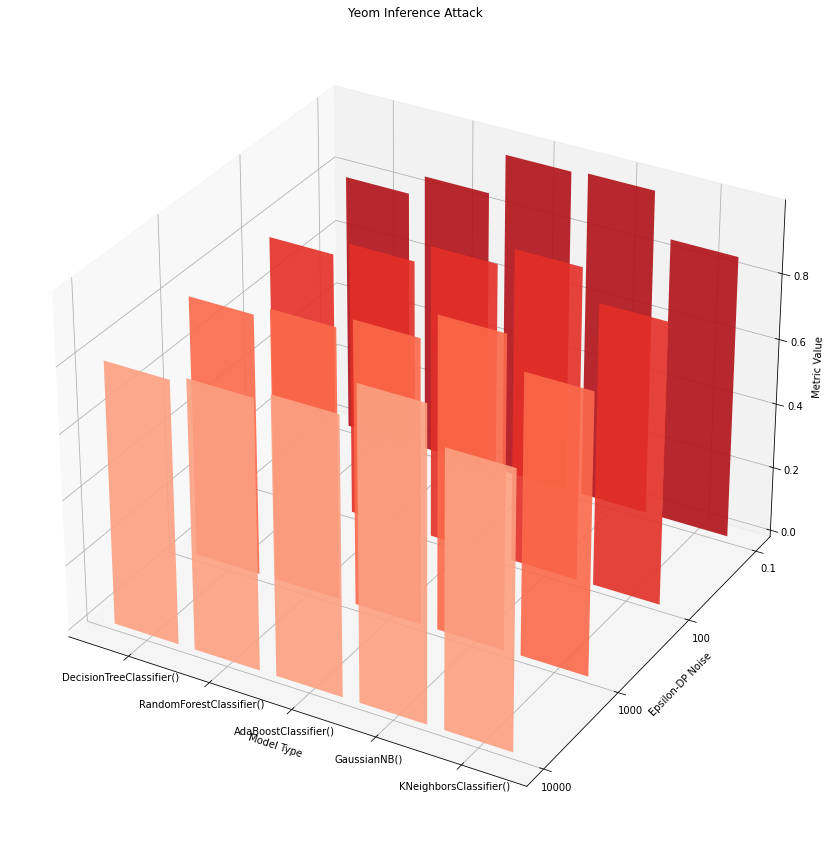

In [63]:
metrics = ['Salem Inference Attack','Yeom Inference Attack']
classifiers = [DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GaussianNB(),KNeighborsClassifier()]
# classifier = classifiers[0]
epsilons = [10000,1000,100,0.1]

# [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
#                     f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
#                     precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

cm_values = [cm.Oranges,cm.Reds]
cm_dict = {elem[0]:elem[1] for elem in zip(metrics,cm_values)}

def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash


SMALL_VALUE = 0.001

def cust_log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]


for metric in metrics:

    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')

    cmap = cm.ScalarMappable(col.Normalize(-2, len(epsilons)),cm_dict[metric])


    for i,epsilon  in enumerate(epsilons):

        ### ADD DP-NOISE TO COMPLETE DATASET ###
        X_train_dash = add_dp_noise(X_train,epsilon)
        X_test_dash = add_dp_noise(X_test,epsilon)
        # classifier = RandomForestClassifier()
   
        calculated_metrics = list()

        for classifier in classifiers: 
            classifier.fit(X_train_dash,y_train)
            n_classes = len(y_test['isFraud'].unique())

            y_train_pred = classifier.predict(X_train_dash.values)
            y_train_pred_probs = classifier.predict_proba(X_train_dash.values)
            train_acc = accuracy_score(y_train,y_train_pred)

            train_loss = cust_log_loss(y_train.values,y_train_pred_probs)
            sk_log_loss = log_loss(y_train.values,y_train_pred_probs)

            y_test_pred = classifier.predict(X_test_dash)
            y_test_pred_probs = classifier.predict_proba(X_test_dash.values)
            test_loss = cust_log_loss(y_test.values,y_test_pred_probs)
            X_attack, y_attack = np.array([]), np.array([])
            
            X_attack = np.append(y_train_pred_probs,y_test_pred_probs,axis=0)
            y_attack = np.append(np.ones(X_train.shape[0]),np.zeros(X_test.shape[0]))
            
            # Prediction Probabilities for Complete Dataset
            X_attack = X_attack.astype('float32')
            # Binary Membership Value for Complete Dataset (1 for Training Data, 0 for Testing Data)
            y_attack = y_attack.astype('int32')
        
            if metric == metrics[0]:
                    
                fpr,tpr,thresholds = roc_curve(y_attack, X_attack[:,1], pos_label=0)
                attack_score = auc(fpr,tpr)
                # np.sum(tpr) - np.sum(fpr)
            
            if metric == metrics[1]:
                    
                loss = np.append(train_loss,test_loss)

                ls = cust_log_loss(y.values,X_attack)

                pred_membership = [1 if ls[elem] <= sk_log_loss else 0 for elem in range(len(y.values))]
                fpr, tpr, thresholds = roc_curve(y_attack, pred_membership, pos_label=0)
                attack_score = auc(tpr,fpr)
                # np.sum(tpr) - np.sum(fpr)
    
            calculated_metrics.append(attack_score)
            # metric_dict = {elem[0]:elem[1] for elem in zip(metrics,metric_values)}
            # calculated_metrics.append(metric_dict[metric])
   
        ax.bar([str(elem) for elem in classifiers], [elem for elem in calculated_metrics], zs=i*2, zdir='y', alpha=0.9, color=cmap.to_rgba(i))

    ax.set_yticks([elem*2 for elem in range(len(epsilons))])
    ax.set_yticklabels(epsilons)
    ax.set_xlabel('Model Type')
    ax.set_ylabel('Epsilon-DP Noise')
    ax.set_zlabel('Metric Value')
    ax.set_title(str(metric))
    plt.show()

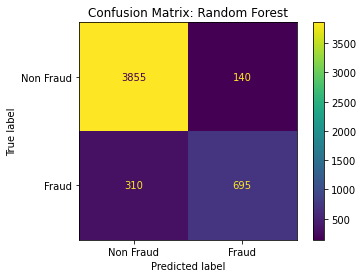

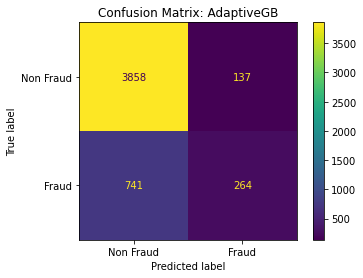

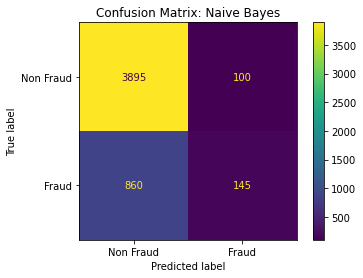

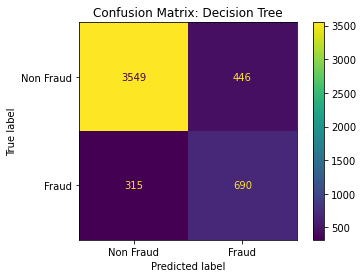

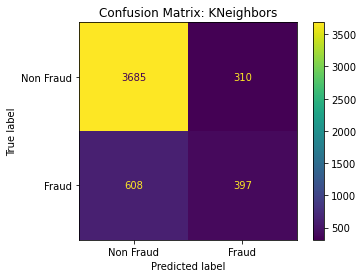

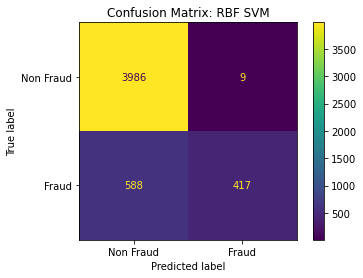

In [19]:
# plt.subplot(1,2,1)

for elem in models.keys():
    plot_confusion_matrix(models[elem], X_test, y_test, display_labels=['Non Fraud','Fraud'])
    plt.title('Confusion Matrix: '+str(elem))


# # plt.subplot(1,2,2)
# plot_confusion_matrix(nb, X_test, y_test, display_labels=['Non Fraud','Fraud'])


# plot_confusion_matrix(ada, X_test, y_test, display_labels=['Non Fraud','Fraud'])

# plot_confusion_matrix(dt, X_test, y_test, display_labels=['Non Fraud','Fraud'])



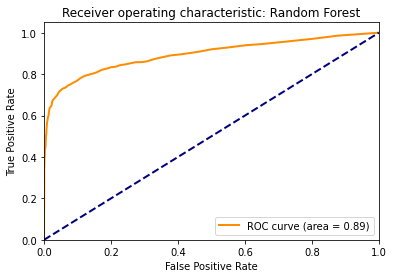

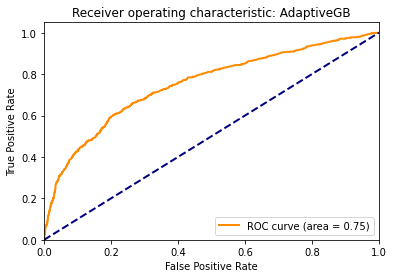

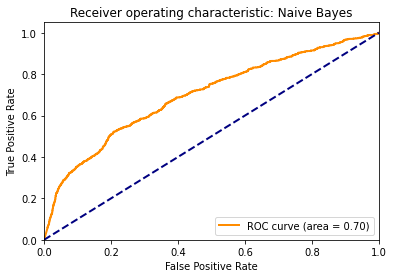

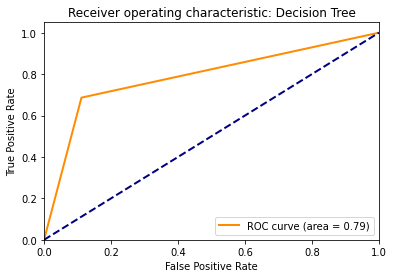

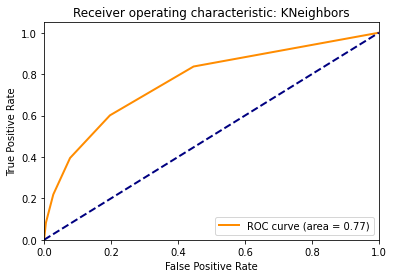

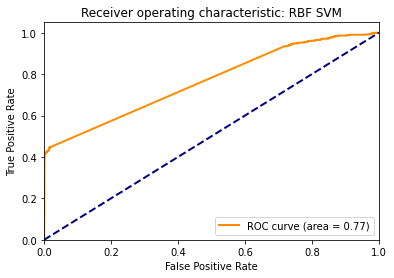

In [20]:
for elem in models.keys():

    # Compute ROC curve and ROC area for each class
    fpr = dict()

    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values[:], models[elem].predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    # plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic: "+str(elem))
    plt.legend(loc="lower right")
    # time.sleep(2)
    plt.show()


In [21]:


res_df = pd.DataFrame()
res_df['Performance Metrics'] = ['ROC_AUC','PR_AUC','F1','RECALL','PRECISION','ACCURACY']

# models = {'Random Forest': rf,'AdaptiveGB':ada,'Naive Bayes':nb,'Decision Tree':dt}
for elem in models.keys():
    res_df[elem] = [roc_auc_score(y_test,models[elem].predict(X_test)),average_precision_score(y_test,models[elem].predict(X_test)),
                    f1_score(y_test,models[elem].predict(X_test)),recall_score(y_test,models[elem].predict(X_test)),
                    precision_score(y_test,models[elem].predict(X_test)),accuracy_score(y_test,models[elem].predict(X_test))] 

res_df

# print('ROC AUC', roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test))
# print('PR AUC', average_precision_score(y_train, y_pred_train), average_precision_score(y_test, y_pred_test))
# print('F1', f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test))
# print('Recall', recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test))
# print('Precision', precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test))
# print('Accuracy', accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

,Performance Metrics,Random Forest,AdaptiveGB,Naive Bayes,Decision Tree,KNeighbors,RBF SVM
0,ROC_AUC,0.828249,0.614197,0.559624,0.787464,0.658714,0.706336
1,PR_AUC,0.637595,0.321141,0.257389,0.480017,0.343417,0.523759
2,F1,0.755435,0.375533,0.232000,0.644559,0.463785,0.582809
3,RECALL,0.691542,0.262687,0.144279,0.686567,0.395025,0.414925
4,PRECISION,0.832335,0.658354,0.591837,0.607394,0.561528,0.978873
5,ACCURACY,0.910000,0.824400,0.808000,0.847800,0.816400,0.880600


In [22]:
def add_dp_noise(x,eps):
    S = x.max(axis=0) - x.min(axis=0)
    B = S/(eps/x.shape[1])
    noise = np.random.laplace(0, B, (x.shape))
    assert x.shape == noise.shape
    x_dash = x + noise
    x_dash = x_dash.astype(np.float32)
    assert x_dash.shape == x.shape
    return x_dash

SMALL_VALUE = 0.001

def cust_log_loss(a, b):
    return [-np.log(max(b[i, a[i]], SMALL_VALUE)) for i in range(len(a))]


In [23]:
X_train.head(3)
add_dp_noise(X_train.head(3),1000)

add_dp_noise(X_train.head(3),100)

add_dp_noise(X_train.head(3),10)

add_dp_noise(X_train.head(3),0.1)


,ProductCD,card4,card6,addr1,addr2,P_emaildomain,PCA1,PCA2
23311,3.0,2.0,0.0,55.0,7.0,46.0,8124.515845,-181.754908
23623,3.0,3.0,1.0,25.0,7.0,16.0,2990.990684,-657.334002
1020,3.0,3.0,1.0,25.0,7.0,2.0,2560.146170,-647.009629


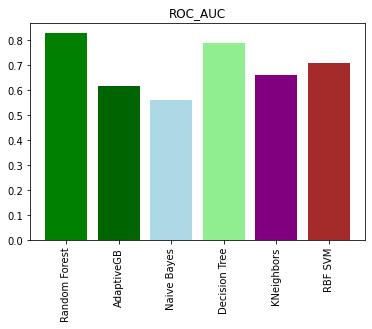

<Figure size 864x360 with 0 Axes>

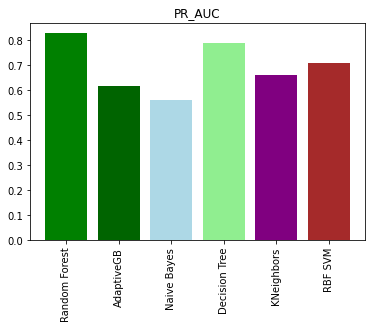

<Figure size 864x360 with 0 Axes>

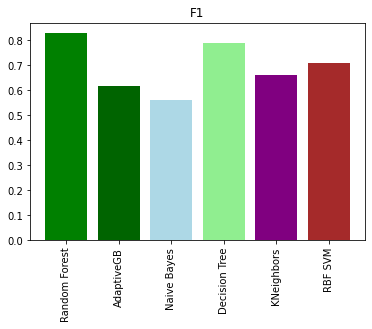

<Figure size 864x360 with 0 Axes>

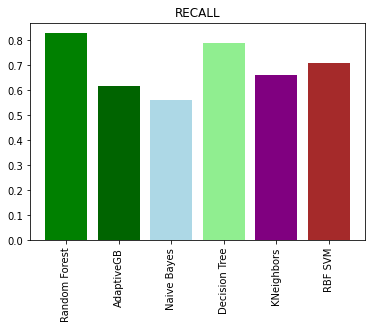

<Figure size 864x360 with 0 Axes>

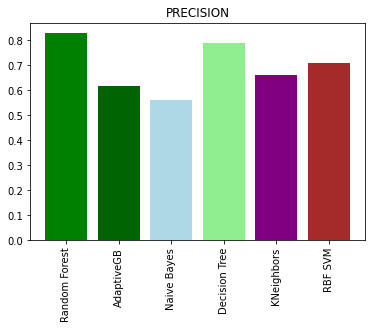

<Figure size 864x360 with 0 Axes>

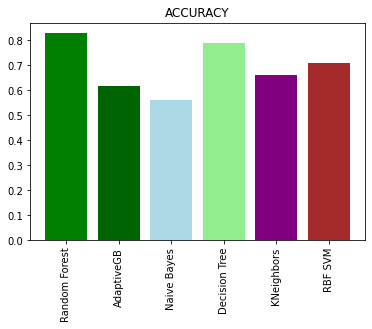

<Figure size 864x360 with 0 Axes>

In [21]:
data = res_df.set_index(res_df['Performance Metrics'],drop=True)
del data['Performance Metrics']
data

for metric in data.index:        

        fig,ax = plt.subplots()
        plt.title(str(metric))
        plt.xticks(rotation=90)

        plt.figure(figsize=(12,5))

        
        ax.bar([elem for elem in data.columns],data.loc['ROC_AUC'].values,label=['ROC_AUC'],
                color=['green','darkgreen','lightblue','lightgreen','purple','brown'])
        
        # ax.legend()

Classifier: Decision Tree
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 -0.022 0.579 0.21
0.05 -0.015 0.585 0.21
0.1 -0.008 0.592 0.2
0.5 -0.015 0.586 0.2
1 -0.015 0.586 0.21
5 -0.02 0.58 0.22
10 -0.003 0.597 0.21
50 -0.008 0.593 0.19
100 -0.014 0.586 0.18
500 -0.012 0.589 0.14
1000 -0.007 0.594 0.12


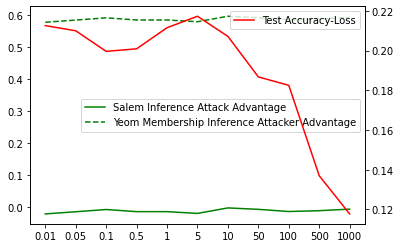

<Figure size 720x360 with 0 Axes>

In [22]:
### COMPLETE EXPERIMENT TENTATIVE ###

### DEFINE PARAMETERS ###

epsilons = [0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]
rounds = 2

non_fitted_models = {'Random Forest': RandomForestClassifier(random_state=42),
 'AdaptiveGB': AdaBoostClassifier(random_state=42),
 'Naive Bayes': GaussianNB(),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'KNeighbors': KNeighborsClassifier(),
 'RBF SVM': SVC(C=1, gamma=2, probability=True)}


model_type = list(non_fitted_models.keys())[3]

# add_s1_noise = False
### default not used when previous value set to True ###
# default_noise_value = 100
# use_non_dp_defaults = True

# X_train, X_test, y_train, y_test = train_test_split(asset_location_data[classifier_input],asset_location_data[classifier_target], test_size=0.2,random_state=50)
# X = X_train.append(X_test)
# y = y_train.append(y_test)



print('Classifier: '+str(model_type))
print('Varying DP Noise Applied at Stage:')
# if add_s1_noise is True:
print('1 (Before Model Training')
# if add_s1_noise is False:
#     print('2 (During Model Training')


print('epsilon','salem_mi','yeom_mi','test_acc_loss')

salem_mis = list()
yeom_mis = list()
test_accs = list()

### RUN FOR LOOP TO GENERATE PERFORMANCE & PRIVACY METRICS FOR DIFFERENT PRIVACY BUDGETS ###
for epsilon  in epsilons:
    salem_mi = 0 
    yeom_mi = 0
    test_acc = 0

    for i in range(rounds):

        # dp_model_list = {'lr':DPLogisticRegression(epsilon=epsilon),
        #              'nb':DPGaussianNB(epsilon=epsilon),
        #              'rf':DPRandomForestClassifier(epsilon=epsilon)
        #             }
        # if use_non_dp_defaults is True:
        #     non_dp_model_list = {'lr':LogisticRegression(),
        #                     'nb':GaussianNB(),
        #                     'rf':RandomForestClassifier()
        #                     }
        # if use_non_dp_defaults is False:
        #     non_dp_model_list = {'lr':LogisticRegression(epsilon=10000),
        #                     'nb':GaussianNB(epsilon=10000),
        #                     'rf':RandomForestClassifier(epsilon=10000)
        #                     }
        # # assert model_type in dp_model_list.keys() and non_dp_model_list.keys()


        # dp_classifier = dp_model_list[model_type]
        # non_dp_classifier = non_dp_model_list[model_type]


        # if add_s1_noise is True:    
        ### ADD DP-NOISE TO COMPLETE DATASET ###
        X_train_dash = add_dp_noise(X_train,epsilon)
        X_test_dash = add_dp_noise(X_test,epsilon)
        classifier = copy.deepcopy(non_fitted_models[model_type])

        # if add_s1_noise is False:

        #     X_train_dash = add_dp_noise(X_train,default_noise_value)
        #     X_test_dash = add_dp_noise(X_test,default_noise_value)
        #     classifier = copy.deepcopy(non_fitted_models[model_type])


        n_classes = len(y_test['isFraud'].unique())


        classifier.fit(X_train_dash,y_train)
        y_train_pred = classifier.predict(X_train_dash.values)
        y_train_pred_probs = classifier.predict_proba(X_train_dash.values)
        train_acc = accuracy_score(y_train,y_train_pred)
        

        train_loss = cust_log_loss(y_train.values,y_train_pred_probs)
        sk_log_loss = log_loss(y_train.values,y_train_pred_probs)

        y_test_pred = classifier.predict(X_test_dash)
        y_test_pred_probs = classifier.predict_proba(X_test_dash.values)
        test_acc = test_acc + (1-(accuracy_score(y_test,y_test_pred)/accuracy_score(y_test,copy.deepcopy(non_fitted_models[model_type]).fit(X_train,y_train).predict(X_test))))
        test_loss = cust_log_loss(y_test.values,y_test_pred_probs)
        X_attack, y_attack = np.array([]), np.array([])

        
        X_attack = np.append(y_train_pred_probs,y_test_pred_probs,axis=0)
        y_attack = np.append(np.ones(X_train.shape[0]),np.zeros(X_test.shape[0]))

        # Prediction Probabilities for Complete Dataset
        X_attack = X_attack.astype('float32')
        # Binary Membership Value for Complete Dataset (1 for Training Data, 0 for Testing Data)
        y_attack = y_attack.astype('int32')

        
        fpr,tpr,thresholds = roc_curve(y_attack, X_attack[:,1], pos_label=1)
        salem_mi = salem_mi + (tpr[1] + tpr[0] -fpr[0]-fpr[1])
        # auc(tpr,fpr)

        loss = np.append(train_loss,test_loss)

        ls = cust_log_loss(y.values,X_attack)

        pred_membership = [1 if ls[elem] <= sk_log_loss else 0 for elem in range(len(y.values))]
        fpr, tpr, thresholds = roc_curve(y_attack, pred_membership, pos_label=1)
        yeom_mi = yeom_mi +( tpr[1] + tpr[0] -fpr[1] -fpr[0])
        # tpr[1]-fpr[1]
        

        attr_adv, attr_mem, attr_pred = [], [], []

        # for feature in features:
            


        
        # print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))
    
    salem_mi = salem_mi/rounds
    yeom_mi = yeom_mi/rounds
    test_acc = test_acc/rounds

    print(epsilon,round(salem_mi,3),round(yeom_mi,3),round(test_acc,2))

    salem_mis.append(salem_mi)
    yeom_mis.append(yeom_mi)
    test_accs.append(test_acc)


fig,ax = plt.subplots()
plt.figure(figsize=(10,5))

ax2 = ax.twinx()

ax.plot([str(elem) for elem in epsilons],salem_mis,label='Salem Inference Attack Advantage',color='green')
ax.plot([str(elem) for elem in epsilons],yeom_mis,label='Yeom Membership Inference Attacker Advantage',color='green',linestyle='dashed')
# ax.plot([str(elem) for elem in epsilons],np.ones(len(epsilons)),label='Attribute Inference Attack Advantage')
ax2.plot([str(elem) for elem in epsilons],test_accs,label='Test Accuracy-Loss',color='red')

ax.legend()
ax2.legend()
# plt.semilogx(epsilons, accuracy)
# plt.yscale('symlog')
# ax.title("Performance-Privacy Tradeoff")
# ax.xlabel("epsilon")
# ax.ylabel("Score")

Classifier: KNeighbors
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 -0.0 0.726 0.06
0.05 0.0 0.728 0.07
0.1 0.0 0.726 0.06
0.5 0.0 0.729 0.07
1 0.0 0.73 0.06
5 0.0 0.737 0.06
10 -0.0 0.727 0.06
50 -0.001 0.725 0.07
100 -0.0 0.724 0.06
500 -0.0 0.717 0.04
1000 -0.0 0.713 0.03


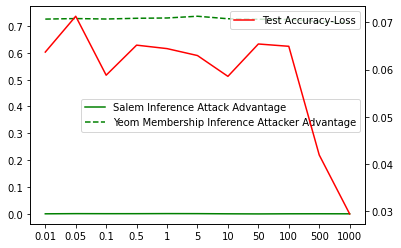

<Figure size 720x360 with 0 Axes>

Classifier: Decision Tree
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 -0.01 0.591 0.2
0.05 -0.014 0.586 0.22
0.1 -0.013 0.588 0.2
0.5 -0.016 0.584 0.21
1 -0.026 0.574 0.21
5 0.0 0.601 0.21
10 -0.007 0.594 0.2
50 -0.012 0.588 0.19
100 -0.007 0.594 0.17
500 -0.001 0.599 0.14
1000 -0.004 0.597 0.12


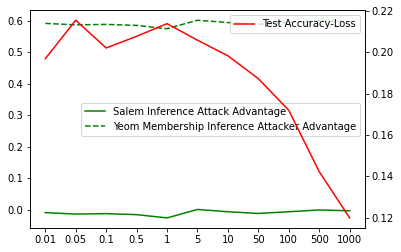

<Figure size 720x360 with 0 Axes>

Classifier: Naive Bayes
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 -0.0 0.999 0.01
0.05 -0.0 0.999 0.01
0.1 0.0 1.0 0.01
0.5 0.0 1.0 0.01
1 0.0 1.0 0.01
5 -0.0 1.0 0.01
10 0.0 1.0 0.01
50 -0.0 0.959 0.01
100 0.0 0.91 0.02
500 0.001 0.91 0.0
1000 0.001 0.905 0.0


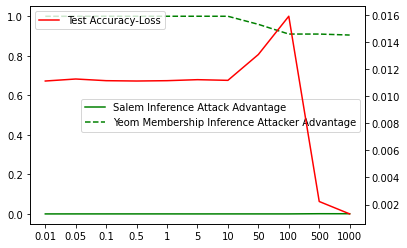

<Figure size 720x360 with 0 Axes>

Classifier: AdaptiveGB
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.0 0.989 0.03
0.05 -0.0 0.991 0.03
0.1 -0.0 0.991 0.03
0.5 0.0 0.988 0.03
1 -0.0 0.989 0.03
5 0.0 0.989 0.03
10 0.0 0.948 0.03
50 -0.0 0.801 0.03
100 0.0 0.801 0.03
500 0.0 0.741 0.02
1000 0.0 0.733 0.01


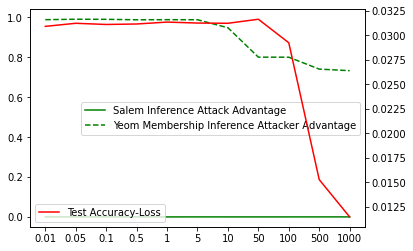

<Figure size 720x360 with 0 Axes>

Classifier: Random Forest
Varying DP Noise Applied at Stage:
1 (Before Model Training
epsilon salem_mi yeom_mi test_acc_loss
0.01 0.0 0.728 0.12
0.05 0.0 0.729 0.12
0.1 0.0 0.728 0.12
0.5 0.0 0.728 0.12
1 0.0 0.728 0.12
5 0.0 0.722 0.12
10 0.0 0.718 0.12
50 0.0 0.699 0.12
100 0.0 0.676 0.12
500 0.0 0.682 0.09
1000 0.0 0.661 0.08


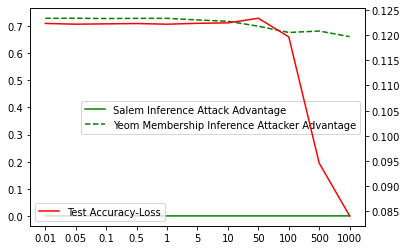

<Figure size 720x360 with 0 Axes>

In [ ]:
# res_df


for col in res_df.columns[1:]:
    res_df[col] = [round(elem,0) for elem in res_df[col]]



In [24]:
res_df

,Performance Metrics,Random Forest,AdaptiveGB,Naive Bayes,Decision Tree,KNeighbors,RBF SVM
0,ROC_AUC,0.828249,0.614197,0.559624,0.787464,0.658714,0.706336
1,PR_AUC,0.637595,0.321141,0.257389,0.480017,0.343417,0.523759
2,F1,0.755435,0.375533,0.232000,0.644559,0.463785,0.582809
3,RECALL,0.691542,0.262687,0.144279,0.686567,0.395025,0.414925
4,PRECISION,0.832335,0.658354,0.591837,0.607394,0.561528,0.978873
5,ACCURACY,0.910000,0.824400,0.808000,0.847800,0.816400,0.880600


In [ ]:
res_au = pd.read_csv('res_au.csv')
res_ieee =  res_df

In [ ]:
res_au[res_au['Performance Metrics']==res_df['Performance Metrics'][0]][classifier].values

array([0.607])

In [ ]:
res_cd = pd.DataFrame(columns=['classifier_name','dataset_name',metric])
res_cd.append({'classifier_name':1,'dataset_name':2,metric:3},ignore_index=True)

,classifier_name,dataset_name,ACCURACY
0,1,2,3


In [ ]:
for metric in res_df['Performance Metrics']:

    res_cd = pd.DataFrame(columns=['classifier_name','dataset_name','accuracy'])
    # res_cd.columns = 

    for classifier in res_df.columns[1:]:
        for dataset in zip([res_au,res_ieee],['ieee','internal']):
            res_cd = res_cd.append({'classifier_name':str(classifier),'dataset_name':str(dataset[1]),'accuracy':dataset[0][dataset[0]['Performance Metrics']==metric][classifier].values[0]},ignore_index=True)

    res_cd.to_csv('res_cd_'+str(metric)+'.csv')


In [ ]:
pd.read_csv('res_cd_ACCURACY.csv')[pd.read_csv('res_cd_ACCURACY.csv').columns[1:]]


NameError: name 'pd' is not defined

In [ ]:
res_df.to_csv('res_ieee.csv')

In [ ]:
X_train.reset_index(drop=True).head(9)
# .to_csv('df_ieee.csv')

,ProductCD,card4,card6,addr1,addr2,P_emaildomain,PCA1,PCA2
0,3.0,2.0,0.0,55.0,7.0,46.0,8124.515845,-181.754908
1,3.0,3.0,1.0,25.0,7.0,16.0,2990.990684,-657.334002
2,3.0,3.0,1.0,25.0,7.0,2.0,2560.146170,-647.009629
3,3.0,2.0,0.0,17.0,7.0,16.0,-7362.758427,-299.291487
4,3.0,2.0,1.0,6.0,7.0,2.0,-1542.775640,-558.543632
5,3.0,2.0,1.0,40.0,7.0,39.0,7189.170611,-743.011375
6,3.0,3.0,0.0,6.0,7.0,16.0,8325.759289,-759.213161
7,3.0,3.0,1.0,50.0,7.0,16.0,7245.959074,-752.694999
8,3.0,3.0,1.0,54.0,7.0,46.0,2758.591670,-437.267627


In [ ]:
df = X_train.reset_index(drop=True).head(9)

for col in ['PCA1','PCA2']:
    df[col] = [round(elem,2) for elem in df[col]]

df.to_csv('df_ieee.csv')

In [ ]:
for epsilon in [1000,100,10,0.1]:

    df_dp = add_dp_noise(X_train.reset_index(drop=True).head(9),epsilon)

    for col in df_dp.columns:
        df_dp[col] = [round(elem,3) for elem in df_dp[col]]
    

    df_dp.to_csv('df_dp_'+str(epsilon)+'_ieee.csv')